## Bibliotecas

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.tree import plot_tree

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import time

## Introdução

O objetivo deste estudo é analisar a performance de modelos baseados em árvores (Decision Tree Regression, Random Forest e XGBoost) para a previsão da inflação medida no Brasil. A previsão da inflação é um tema de suma importância visto impactar a condução da política monetária, o orçamento federal e a precificação de ativos pelos agentes de mercado e preve-la é um grande desafio devida a dinâmica não-linear da inflação que pode não ser capturada por metodologias tradicionais. 

A inflação pode ser definida como o aumento generalizado dos preços, muitas teorias se proporam a explicar o fenômeno da inflação como a Teoria Quantitativa da Moeda de Fisher e a Teoria das Expectativas Racionais de Lucas. Além das teorias que buscam explicar a inflação, há inúmeras abordagens que buscam prever a inflação, conforme apontado por Araujo e Gaglianone (2022) os economistas utilizam: "modelos de séries temporais, modelos estruturais (por exemplo, Curva de Phillips), modelos de preços de ativos (por exemplo, estrutura a termo das taxas de juros) e métodos que utilizam medidas baseadas em pesquisas (por exemplo, pesquisa de previsores profissionais)".

Fontes:
- https://www.bcb.gov.br/content/publicacoes/WorkingPaperSeries/wps561.pdf

## Base de Dados

A base de dados foi extraída do Sistema Gerenciador de Séries Temporais (SGS) do Banco Central, a escolha das variáveis (feature selection) é baseado no box 'Modelos de Vetores Autorregressivos' presente no Relatório de Inflação de junho de 2010 que comenta sobre o uso de modelos de vetores autorregressivos para previsão de inflação e traz algumas variáveis utilizadas para rodar os modelos.

Variáveis:
- IPCA
- Taxa de Câmbio
- Taxa de Juros (Selic)
- Preços Administrados
- Preços Livres

In [5]:
data = pd.read_excel(r'C:\Users\emanu\Downloads\bcb_series.xlsx')
data.tail(6)

,Data,433 - Índice nacional de preços ao consumidor-amplo (IPCA) - Var. % mensal,3695 - Taxa de câmbio - Livre - Dólar americano (compra) - Fim de período - mensal - u.m.c./US$,4189 - Taxa de juros - Selic acumulada no mês anualizada base 252 - % a.a.,4449 - Índice Nacional de Preços ao Consumidor - Amplo (IPCA) - Administrados - Var. % mensal,11428 - Índice nacional de preços ao consumidor - Amplo (IPCA) - Itens livres - Var. % mensal
861,2024-10-01 00:00:00,0.56,5.7773,10.65,0.71,0.51
862,2024-11-01 00:00:00,0.39,6.0529,11.04,-0.87,0.84
863,2024-12-01 00:00:00,0.52,6.1917,11.77,-0.17,0.76
864,2025-01-01 00:00:00,0.16,-,12.24,-1.52,0.75
865,2025-02-01 00:00:00,-,-,13.15,-,-
866,Fonte,IBGE,Sisbacen PTAX800,BCB-Demab,BCB-Depec,BCB-Depec


In [6]:
data = data.replace("-",np.nan).dropna().iloc[:-1,:] # Substituir - por NaN e dropar
data = data.iloc[-240:,:] # Selecionar últimos 20 anos
data.tail(6)

,Data,433 - Índice nacional de preços ao consumidor-amplo (IPCA) - Var. % mensal,3695 - Taxa de câmbio - Livre - Dólar americano (compra) - Fim de período - mensal - u.m.c./US$,4189 - Taxa de juros - Selic acumulada no mês anualizada base 252 - % a.a.,4449 - Índice Nacional de Preços ao Consumidor - Amplo (IPCA) - Administrados - Var. % mensal,11428 - Índice nacional de preços ao consumidor - Amplo (IPCA) - Itens livres - Var. % mensal
858,2024-07-01 00:00:00,0.38,5.6615,10.4,1.08,0.13
859,2024-08-01 00:00:00,-0.02,5.6556,10.4,-0.12,0.02
860,2024-09-01 00:00:00,0.44,5.4475,10.5,1.01,0.24
861,2024-10-01 00:00:00,0.56,5.7773,10.65,0.71,0.51
862,2024-11-01 00:00:00,0.39,6.0529,11.04,-0.87,0.84
863,2024-12-01 00:00:00,0.52,6.1917,11.77,-0.17,0.76


In [7]:
data['Data'] = pd.to_datetime(data['Data'])
data = data.set_index('Data', drop=True)
data

,433 - Índice nacional de preços ao consumidor-amplo (IPCA) - Var. % mensal,3695 - Taxa de câmbio - Livre - Dólar americano (compra) - Fim de período - mensal - u.m.c./US$,4189 - Taxa de juros - Selic acumulada no mês anualizada base 252 - % a.a.,4449 - Índice Nacional de Preços ao Consumidor - Amplo (IPCA) - Administrados - Var. % mensal,11428 - Índice nacional de preços ao consumidor - Amplo (IPCA) - Itens livres - Var. % mensal
Data,,,,,
2005-01-01,0.58,2.624,17.93,0.51,0.61
2005-02-01,0.59,2.5942,18.47,0.16,0.77
2005-03-01,0.61,2.6654,18.97,1.29,0.33
2005-04-01,0.87,2.5305,19.32,1.14,0.76
2005-05-01,0.49,2.403,19.61,0.25,0.59
...,...,...,...,...,...
2024-08-01,-0.02,5.6556,10.4,-0.12,0.02
2024-09-01,0.44,5.4475,10.5,1.01,0.24
2024-10-01,0.56,5.7773,10.65,0.71,0.51


In [8]:
data.columns = ['IPCA', 'Cambio', 'Selic', 'Precos Administrado', 'Precos Livres'] # Nome de Colunas mas inteligíveis
data.tail(6)

,IPCA,Cambio,Selic,Precos Administrado,Precos Livres
Data,,,,,
2024-07-01,0.38,5.6615,10.4,1.08,0.13
2024-08-01,-0.02,5.6556,10.4,-0.12,0.02
2024-09-01,0.44,5.4475,10.5,1.01,0.24
2024-10-01,0.56,5.7773,10.65,0.71,0.51
2024-11-01,0.39,6.0529,11.04,-0.87,0.84
2024-12-01,0.52,6.1917,11.77,-0.17,0.76


In [9]:
data = data.astype(float) # Garantido que as variáveis estejam no formato float
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 240 entries, 2005-01-01 to 2024-12-01
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   IPCA                 240 non-null    float64
 1   Cambio               240 non-null    float64
 2   Selic                240 non-null    float64
 3   Precos Administrado  240 non-null    float64
 4   Precos Livres        240 non-null    float64
dtypes: float64(5)
memory usage: 11.2 KB


<Axes: xlabel='Data'>

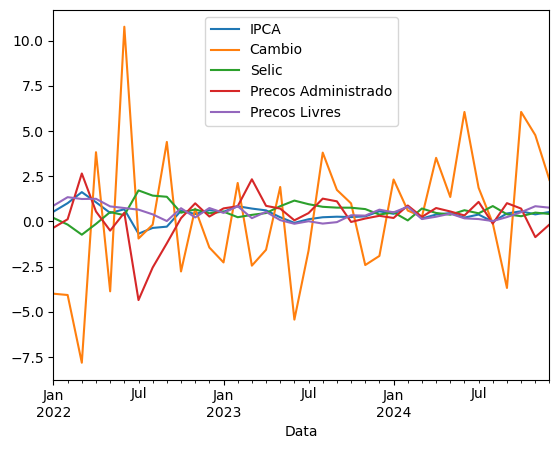

In [10]:
data['Selic'] = ((1+data['Selic']/100)**(1/12)-1)*100 - data['IPCA'] # Calculo da taxa de juros real em base mensal
data['Cambio'] = data['Cambio'].pct_change()*100
data.dropna(inplace=True)
data.tail(36).plot()

In [11]:
data.describe()

,IPCA,Cambio,Selic,Precos Administrado,Precos Livres
count,239.000000,239.000000,239.000000,239.000000,239.000000
mean,0.453180,0.460407,0.380789,0.463389,0.452092
std,0.329898,4.540386,0.452363,0.769616,0.342678
min,-0.680000,-10.719154,-1.193029,-4.350000,-0.350000
25%,0.250000,-2.528231,0.138735,0.160000,0.190000
50%,0.430000,-0.012900,0.401786,0.380000,0.430000
75%,0.610000,3.138013,0.675048,0.775000,0.685000
max,1.620000,17.133937,1.714853,3.360000,1.440000


### Variáveis Dependente e Independentes

As variáveis independentes foram defasadas em até três períodos para poder capturar como valores passados em diferentes janelas de tempo impactam valores futuros. 

In [13]:
colunas = data.columns[1:]
colunas

Index(['Cambio', 'Selic', 'Precos Administrado', 'Precos Livres'], dtype='object')

In [14]:
X = pd.DataFrame()

# Defasagens
for i in colunas: 
    X[f'{i} (t-1)'] = data[i].shift(1)
    X[f'{i} (t-2)'] = data[i].shift(2)
    X[f'{i} (t-3)'] = data[i].shift(3)

X.dropna(inplace=True)
X # Variáveis dependentes (Features)

,Cambio (t-1),Cambio (t-2),Cambio (t-3),Selic (t-1),Selic (t-2),Selic (t-3),Precos Administrado (t-1),Precos Administrado (t-2),Precos Administrado (t-3),Precos Livres (t-1),Precos Livres (t-2),Precos Livres (t-3)
Data,,,,,,,,,,,,
2005-05-01,-5.061154,2.744584,-1.135671,0.612877,0.848037,0.832435,1.14,1.29,0.16,0.76,0.33,0.77
2005-06-01,-5.038530,-5.061154,2.744584,1.013408,0.612877,0.848037,0.25,1.14,1.29,0.59,0.76,0.33
2005-07-01,-2.222222,-5.038530,-5.061154,1.533303,1.013408,0.612877,-0.16,0.25,1.14,0.04,0.59,0.76
2005-08-01,1.706673,-2.222222,-5.038530,1.261184,1.533303,1.013408,0.84,-0.16,0.25,0.00,0.04,0.59
2005-09-01,-1.121480,1.706673,-2.222222,1.343303,1.261184,1.533303,0.69,0.84,-0.16,-0.05,0.00,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,1.856683,6.054188,1.349783,0.447908,0.617908,0.372473,1.08,0.33,0.55,0.13,0.17,0.43
2024-09-01,-0.104213,1.856683,6.054188,0.847908,0.447908,0.617908,-0.12,1.08,0.33,0.02,0.13,0.17
2024-10-01,-3.679539,-0.104213,1.856683,0.395516,0.847908,0.447908,1.01,-0.12,1.08,0.24,0.02,0.13


In [15]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 236 entries, 2005-05-01 to 2024-12-01
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Cambio (t-1)               236 non-null    float64
 1   Cambio (t-2)               236 non-null    float64
 2   Cambio (t-3)               236 non-null    float64
 3   Selic (t-1)                236 non-null    float64
 4   Selic (t-2)                236 non-null    float64
 5   Selic (t-3)                236 non-null    float64
 6   Precos Administrado (t-1)  236 non-null    float64
 7   Precos Administrado (t-2)  236 non-null    float64
 8   Precos Administrado (t-3)  236 non-null    float64
 9   Precos Livres (t-1)        236 non-null    float64
 10  Precos Livres (t-2)        236 non-null    float64
 11  Precos Livres (t-3)        236 non-null    float64
dtypes: float64(12)
memory usage: 24.0 KB


In [16]:
y = data['IPCA'].copy() # Variável independente (Target)
y

Data
2005-02-01    0.59
2005-03-01    0.61
2005-04-01    0.87
2005-05-01    0.49
2005-06-01   -0.02
              ... 
2024-08-01   -0.02
2024-09-01    0.44
2024-10-01    0.56
2024-11-01    0.39
2024-12-01    0.52
Name: IPCA, Length: 239, dtype: float64

In [17]:
y = y.iloc[3:] # Garantindo o mesmo número de observações
y.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 236 entries, 2005-05-01 to 2024-12-01
Series name: IPCA
Non-Null Count  Dtype  
--------------  -----  
236 non-null    float64
dtypes: float64(1)
memory usage: 3.7 KB


### Base de Treino e Teste

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

y_train

Data
2005-05-01    0.49
2005-06-01   -0.02
2005-07-01    0.25
2005-08-01    0.17
2005-09-01    0.35
              ... 
2020-08-01    0.24
2020-09-01    0.64
2020-10-01    0.86
2020-11-01    0.89
2020-12-01    1.35
Name: IPCA, Length: 188, dtype: float64

## Introdução aos Modelos Baseados em Árvores

Modelos baseados em árvores são algoritmos de aprendizado supervisionado que podem ser usados tanto para regressão quanto para classificação. Esses modelos organizam a tomada de decisão em forma de uma árvore separando a base de dados em raiz, ramos e folhas. Segue um resumo do funcionamento de árvore de decisão:

1) O processo começa no nó raiz, que recebe toda a base de treinamento (X_train). A cada divisão, o modelo escolhe uma variável (feature) e aplica uma regra de decisão para separar os dados em dois grupos, formando novos nós, a divisão continua até que um critério de parada seja atingido (hiperparâmetros), como a profundidade máxima da árvore ou um número mínimo de amostras por nó.

2) O último nó de cada ramo é chamado de nó folha, que contém a previsão final do modelo. Essa previsão representa o melhor resultado com base no critério definido, como o erro quadrático para regressão ou o gini para classificação.

Os ensamble models são modelos fruto da combinação de dois ou mais modelos diferentes que buscam trazer resultados mais robustos e com menor overfitting. 

Fontes: 
- https://scikit-learn.org/stable/modules/tree.html
- https://bookdown.org/jessicakubrusly/intr-machine-learning-i/_book/cap-arvores.html

### Decision Tree Simples

Primeiro estarei rodando o modelo sem nenhum tipo de otimização. 

In [22]:
dtree = DecisionTreeRegressor(criterion='squared_error', 
                              max_depth=3,
                              min_samples_split=10, 
                              min_samples_leaf=5,
                              ccp_alpha=0) 

dtree.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0, max_depth=3, min_samples_leaf=5,
                      min_samples_split=10)

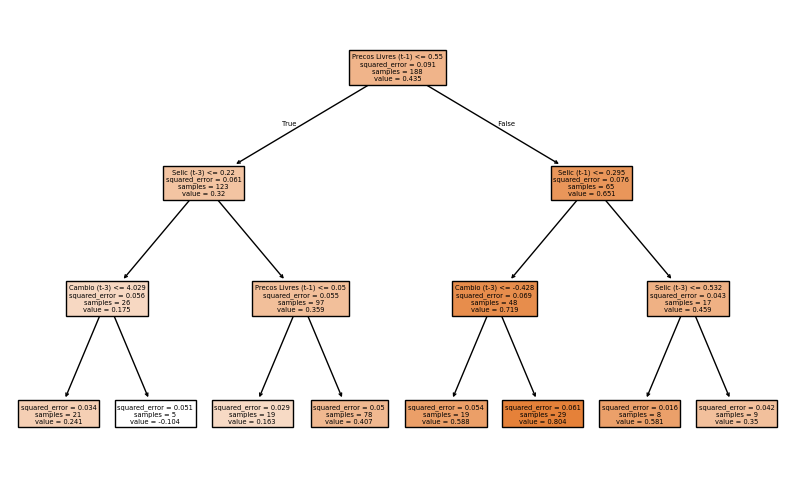

In [23]:
plt.figure(figsize=(10, 6))
plot_tree(dtree, filled=True, feature_names=X.columns)
plt.show()

In [24]:
feature_importance = pd.DataFrame({'Feature':X.columns, 
                                   'Importance':dtree.feature_importances_}
                                 ).sort_values(by='Importance', ascending=False).reset_index(drop=True)

feature_importance[:7]

,Feature,Importance
0,Precos Livres (t-1),0.665383
1,Cambio (t-3),0.121986
2,Selic (t-3),0.111092
3,Selic (t-1),0.101539
4,Cambio (t-1),0.000000
5,Cambio (t-2),0.000000
6,Selic (t-2),0.000000


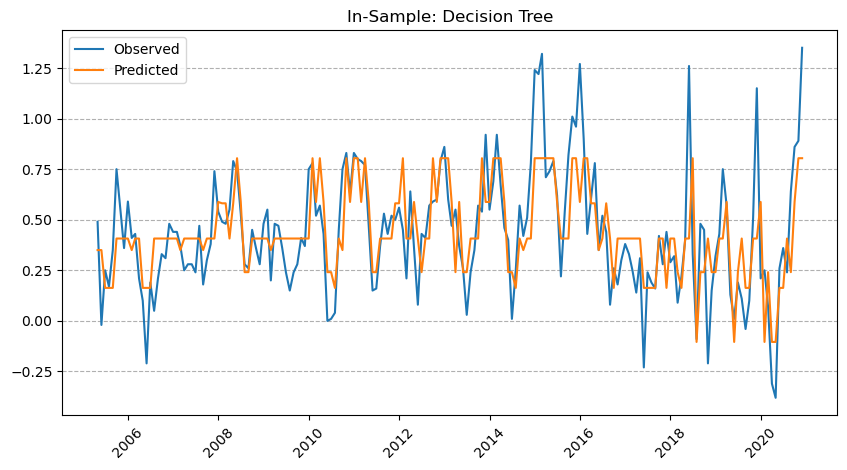

In [25]:
plt.figure(figsize=(10,5))

plt.title('In-Sample: Decision Tree')
plt.plot(y_train, label='Observed')
plt.plot(pd.Series(dtree.predict(X_train), index=y_train.index), label='Predicted')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='dashed')
plt.legend()

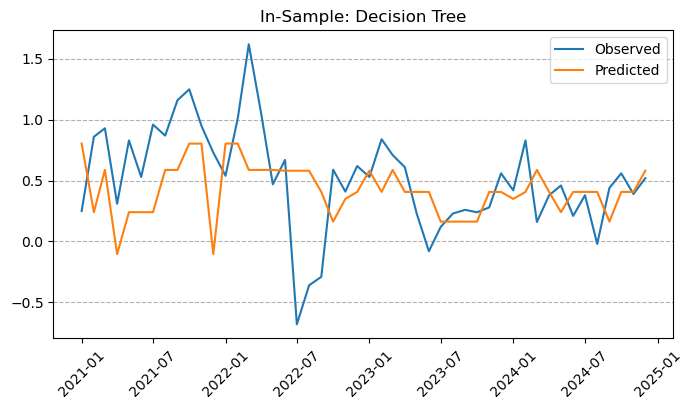

In [26]:
plt.figure(figsize=(8,4))

plt.title('In-Sample: Decision Tree')
plt.plot(y_test, label='Observed')
plt.plot(pd.Series(dtree.predict(X_test), index=y_test.index), label='Predicted')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='dashed')
plt.legend()

## Decision Tree Otimização com Grid Search 

Modelo otimizado com Grid Search, esta técnica funciona testanto diferentes hiperparâmetros até encontrar aquele que minimiza algum critério de otimização, por exemplo, o R2. 

In [28]:
path = dtree.cost_complexity_pruning_path(X_train, y_train) # Poda da arvore, ajuda a equilibrar precisão e simplicidade
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print(ccp_alphas)
print(impurities)

[0.         0.00120473 0.00255609 0.00285521 0.00428125 0.00450426
 0.0246771 ]
[0.04649041 0.04769514 0.05025123 0.05310644 0.06166894 0.0661732
 0.0908503 ]


In [29]:
tempo_ini = time.time()

param_grid = {
    'ccp_alpha': ccp_alphas,
    'max_depth': [15, 20, 30],
    'min_samples_split': [2, 6, 10],
    'min_samples_leaf': [5, 10, 15, 20]
}

grid_search = GridSearchCV(
    estimator = dtree,
    param_grid = param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

tempo_fim = time.time()

print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor pontuação:", grid_search.best_score_)

print(f"Tempo de execução: {tempo_fim - tempo_ini} segundos")

Melhores parâmetros: {'ccp_alpha': 0.0025560914971553246, 'max_depth': 15, 'min_samples_leaf': 20, 'min_samples_split': 6}
Melhor pontuação: -0.05373548561579335
Tempo de execução: 7.302718877792358 segundos


In [30]:
best_dtree = DecisionTreeRegressor(ccp_alpha=grid_search.best_params_['ccp_alpha'], 
                                   max_depth = grid_search.best_params_['max_depth'],
                                   min_samples_leaf = grid_search.best_params_['min_samples_leaf'],
                                   min_samples_split = grid_search.best_params_['min_samples_split'])

best_dtree.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0025560914971553246, max_depth=15,
                      min_samples_leaf=20, min_samples_split=6)

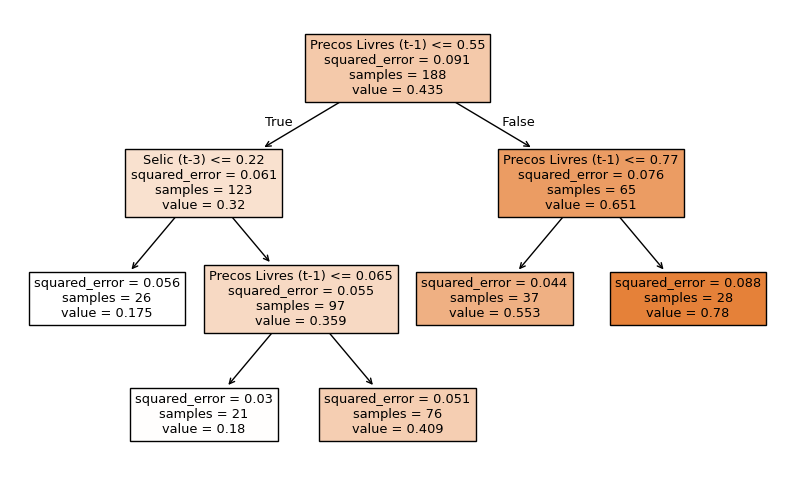

In [31]:
plt.figure(figsize=(10, 6))
plot_tree(best_dtree, filled=True, feature_names=X.columns)
plt.show()

In [32]:
feature_importance = pd.DataFrame({'Feature':X.columns, 
                                   'Importance':best_dtree.feature_importances_}
                                 ).sort_values(by='Importance', ascending=False).reset_index(drop=True)

feature_importance[:7]

,Feature,Importance
0,Precos Livres (t-1),0.900232
1,Selic (t-3),0.099768
2,Cambio (t-1),0.000000
3,Cambio (t-2),0.000000
4,Cambio (t-3),0.000000
5,Selic (t-1),0.000000
6,Selic (t-2),0.000000


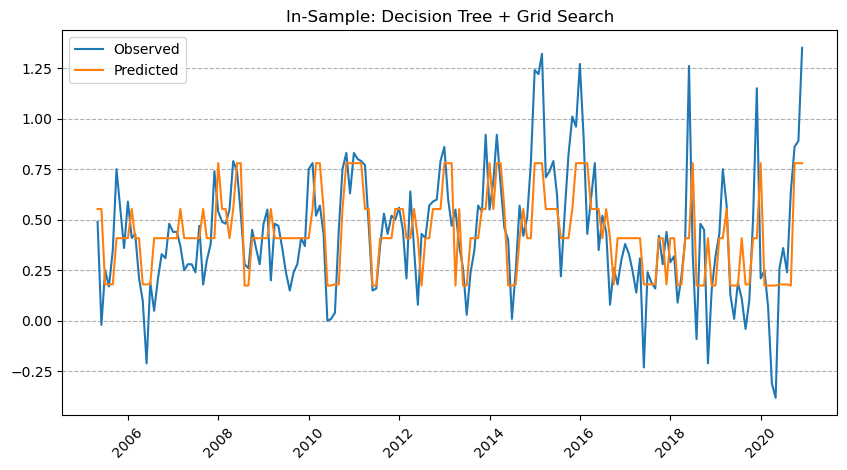

In [33]:
plt.figure(figsize=(10,5))

plt.title('In-Sample: Decision Tree + Grid Search')
plt.plot(y_train, label='Observed')
plt.plot(pd.Series(best_dtree.predict(X_train), index=y_train.index), label='Predicted')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='dashed')
plt.legend()

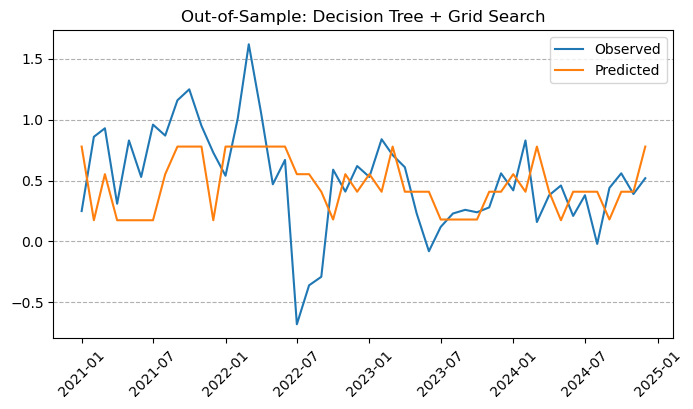

In [34]:
plt.figure(figsize=(8,4))

plt.title('Out-of-Sample: Decision Tree + Grid Search')
plt.plot(y_test, label='Observed')
plt.plot(pd.Series(best_dtree.predict(X_test), index=y_test.index), label='Predicted')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='dashed')
plt.legend()

## Random Forest

No modelo Random Forest, várias árvores de decisão são treinadas de forma independente, utilizando amostras aleatórias dos dados (bootstrap) e um subconjunto aleatório de features para cada divisão. Isso aumenta a diversidade entre as árvores, tornando o modelo mais robusto. Ao final, as previsões individuais das árvores são agregadas para formar um modelo mais forte que traga melhor precisão e menor overfitting. 

In [36]:
tempo_ini = time.time()

param_grid = {
    'n_estimators': [100, 150, 200],  
    'max_depth': [3, 5, 10],  
    'min_samples_split': [10, 15, 20],  
    'min_samples_leaf': [10, 15, 20]
}

rf_model = RandomForestRegressor(criterion='squared_error')

grid_search = GridSearchCV(estimator=rf_model, 
                           param_grid=param_grid, 
                           scoring='r2', 
                           cv=5, 
                           n_jobs=-1)

grid_search.fit(X_train, y_train.values.ravel()) 

print(grid_search)
print(grid_search.best_params_)
print(grid_search.best_score_)

best_rfmodel = grid_search.best_estimator_

tempo_fim = time.time()

print(f"Tempo de execução: {tempo_fim - tempo_ini} segundos")

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10],
                         'min_samples_leaf': [10, 15, 20],
                         'min_samples_split': [10, 15, 20],
                         'n_estimators': [100, 150, 200]},
             scoring='r2')
{'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 100}
0.20720472790554312
Tempo de execução: 17.41429376602173 segundos


In [37]:
feature_importance = pd.DataFrame({'Feature':X.columns, 
                                   'Importance':best_rfmodel.feature_importances_}
                                 ).sort_values(by='Importance', ascending=False).reset_index(drop=True)

feature_importance

,Feature,Importance
0,Precos Livres (t-1),0.596874
1,Selic (t-1),0.104650
2,Precos Administrado (t-1),0.063497
3,Selic (t-3),0.059082
4,Selic (t-2),0.036111
5,Cambio (t-3),0.035192
6,Cambio (t-1),0.027114
7,Precos Administrado (t-2),0.020610
8,Precos Administrado (t-3),0.018444
9,Precos Livres (t-2),0.018100


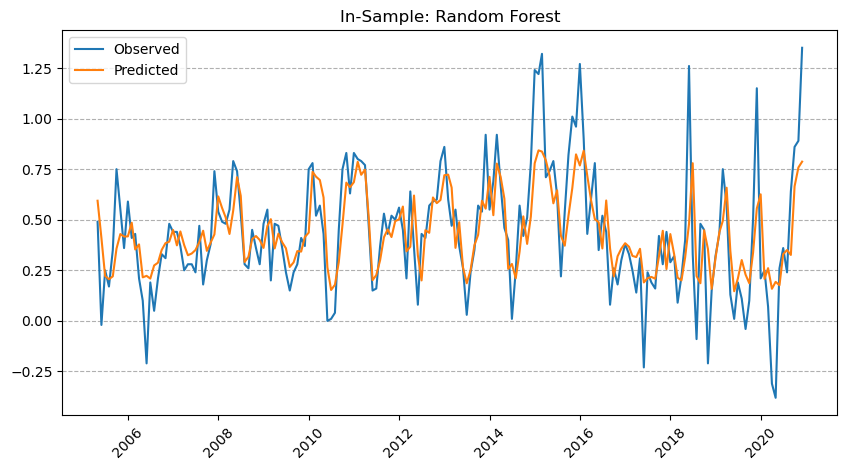

In [38]:
plt.figure(figsize=(10,5))

plt.title('In-Sample: Random Forest')
plt.plot(y_train, label='Observed')
plt.plot(pd.Series(best_rfmodel.predict(X_train), index=y_train.index), label='Predicted')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='dashed')
plt.legend()

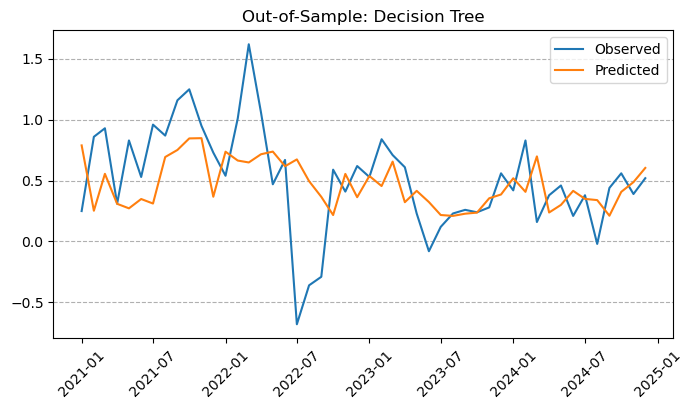

In [39]:
plt.figure(figsize=(8,4))

plt.title('Out-of-Sample: Decision Tree')
plt.plot(y_test, label='Observed')
plt.plot(pd.Series(best_rfmodel.predict(X_test), index=y_test.index), label='Predicted')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='dashed')
plt.legend()

## XGBoost

O XGBoost vem de "*eXtreme Gradient Boosting*" e é um modelo baseado em árvores que de forma sequencial vai treinando árvores e aperfeiçoando elas de forma sequencial visando reduzir os resíduos. A ideia é que cada árvore aprende com os erros da árvore anterior, ajustando suas previsões para reduzir a diferença entre as previsões do modelo e os valores reais, visando minimizar os resíduos de maneira em cada iteração.

In [41]:
tempo_ini = time.time()

xgb_model = XGBRegressor(objective="reg:squarederror")

param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 5, 10, 20],
    'learning_rate': [0.01, 0.05, 0.1]
}

grid_search = GridSearchCV(
    estimator=XGBRegressor(),
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print(grid_search)
print(grid_search.best_params_)
print(grid_search.best_score_)

best_xgb = grid_search.best_estimator_

tempo_fim = time.time()

print(f"Tempo de execução: {tempo_fim - tempo_ini} segundos")

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
       

In [42]:
feature_importance = pd.DataFrame({'Feature':X.columns, 
                                   'Importance':best_xgb.feature_importances_}
                                 ).sort_values(by='Importance', ascending=False).reset_index(drop=True)

feature_importance

,Feature,Importance
0,Precos Livres (t-1),0.246721
1,Selic (t-1),0.118711
2,Selic (t-3),0.081933
3,Precos Administrado (t-1),0.077321
4,Selic (t-2),0.069739
5,Cambio (t-1),0.065580
6,Precos Administrado (t-3),0.062437
7,Precos Livres (t-3),0.059702
8,Precos Livres (t-2),0.059427
9,Cambio (t-3),0.057234


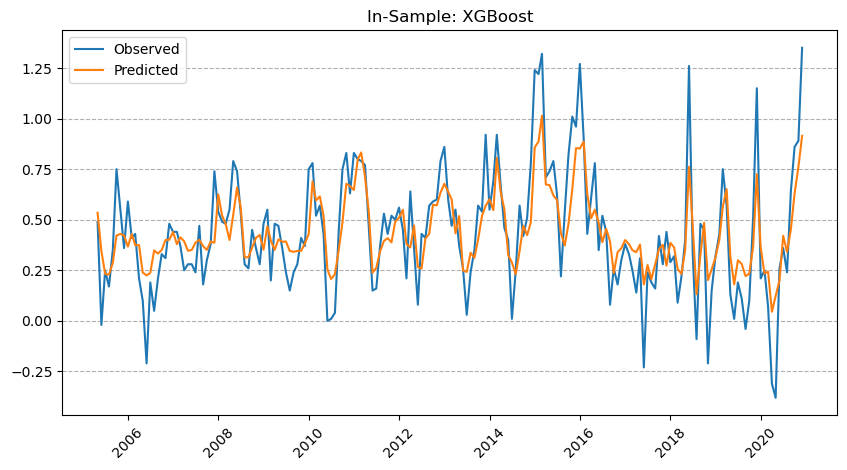

In [43]:
plt.figure(figsize=(10,5))

plt.title('In-Sample: XGBoost')
plt.plot(y_train, label='Observed')
plt.plot(pd.Series(best_xgb.predict(X_train), index=y_train.index), label='Predicted')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='dashed')
plt.legend()

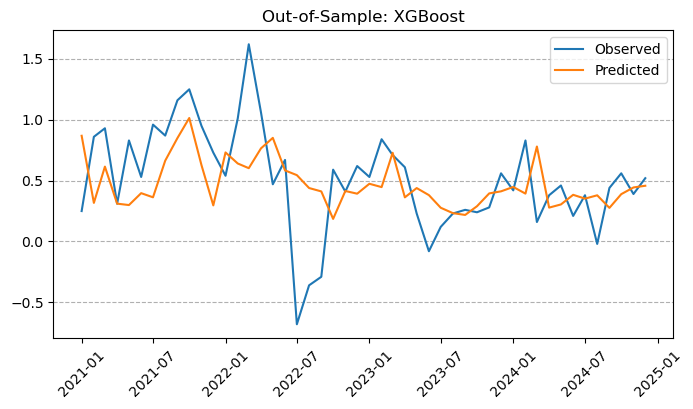

In [44]:
plt.figure(figsize=(8,4))

plt.title('Out-of-Sample: XGBoost')
plt.plot(y_test, label='Observed')
plt.plot(pd.Series(best_xgb.predict(X_test), index=y_test.index), label='Predicted')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='dashed')
plt.legend()

## Comparando os Modelos

### Coeficiente R2

O coeficiente de determinação (R2), é uma métrica que indica o quão bem um modelo de regressão consegue explicar a variabilidade dos dados, ou seja, a proporção da variação da variável dependente que é explicada pelas variáveis independentes do modelo. Abaixo avaliamos como cada um dos modelos foi capaz de explicar os seus valores de treino e constatar com o XGBoost teve o melhor desempenho sendo capaz de explicar 69% da variação da inflação. 

In [47]:
model_past = round(pd.DataFrame({"Observed": y_train,
                           "Decision Tree": best_dtree.predict(X_train),
                           "Random Forest": best_rfmodel.predict(X_train),
                           "XGBoost" : best_xgb.predict(X_train)}, index=X_train.index),2)

model_past.tail(12)

,Observed,Decision Tree,Random Forest,XGBoost
Data,,,,
2020-01-01,0.21,0.78,0.63,0.36
2020-02-01,0.25,0.17,0.21,0.23
2020-03-01,0.07,0.17,0.26,0.24
2020-04-01,-0.31,0.17,0.16,0.05
2020-05-01,-0.38,0.17,0.19,0.12
2020-06-01,0.26,0.18,0.18,0.20
2020-07-01,0.36,0.18,0.33,0.42
2020-08-01,0.24,0.18,0.35,0.34
2020-09-01,0.64,0.17,0.33,0.45


In [48]:
print(model_past.columns[1], ':', r2_score(y_train, model_past.iloc[:,1]))
print(model_past.columns[2], ':', r2_score(y_train, model_past.iloc[:,2]))   
print(model_past.columns[3], ':', r2_score(y_train, model_past.iloc[:,3]))

Decision Tree : 0.41072105872131115
Random Forest : 0.5455406893232544
XGBoost : 0.6683695894356648


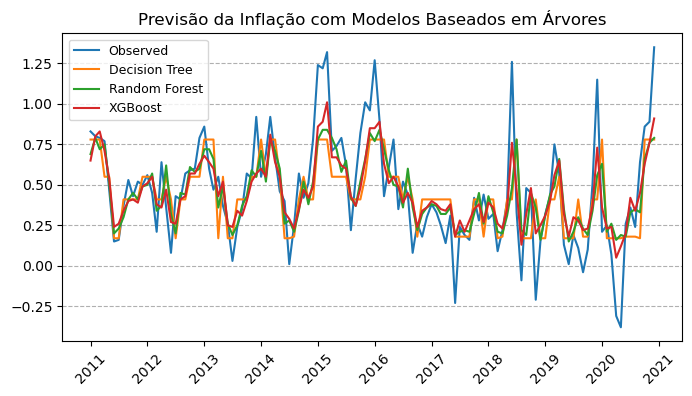

In [113]:
plt.figure(figsize=(8,4))

plt.title('Previsão da Inflação com Modelos Baseados em Árvores')
plt.plot(y_train.tail(120), label = 'Observed')
plt.plot(model_past['Decision Tree'].tail(120), label = model_pred.columns[1])
plt.plot(model_past['Random Forest'].tail(120), label = model_pred.columns[2])
plt.plot(model_past['XGBoost'].tail(120), label = model_pred.columns[3])
plt.legend(fontsize=9)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='dashed')

### Previsões Out-of-Sample

Um dos maiores interesses é verificar o desempenho do modelo com novos dados, ou seja, com dados em que o modelo não foi treinado. No caso podemos ver que o Random Forest e o XGBoost se mostraram os melhores modelos com o Random Forest tendo uma vantagem marginal na maioria das métricas. 

In [50]:
model_pred = round(pd.DataFrame({"Observed": y_test,
                                 "Decision Tree": best_dtree.predict(X_test),
                                 "Random Forest": best_rfmodel.predict(X_test),
                                 "XGBoost" : best_xgb.predict(X_test)}, index=X_test.index),2)

model_pred.tail(12)

,Observed,Decision Tree,Random Forest,XGBoost
Data,,,,
2024-01-01,0.42,0.55,0.52,0.45
2024-02-01,0.83,0.41,0.41,0.39
2024-03-01,0.16,0.78,0.70,0.78
2024-04-01,0.38,0.41,0.24,0.28
2024-05-01,0.46,0.17,0.30,0.30
2024-06-01,0.21,0.41,0.42,0.38
2024-07-01,0.38,0.41,0.35,0.35
2024-08-01,-0.02,0.41,0.34,0.38
2024-09-01,0.44,0.18,0.21,0.28


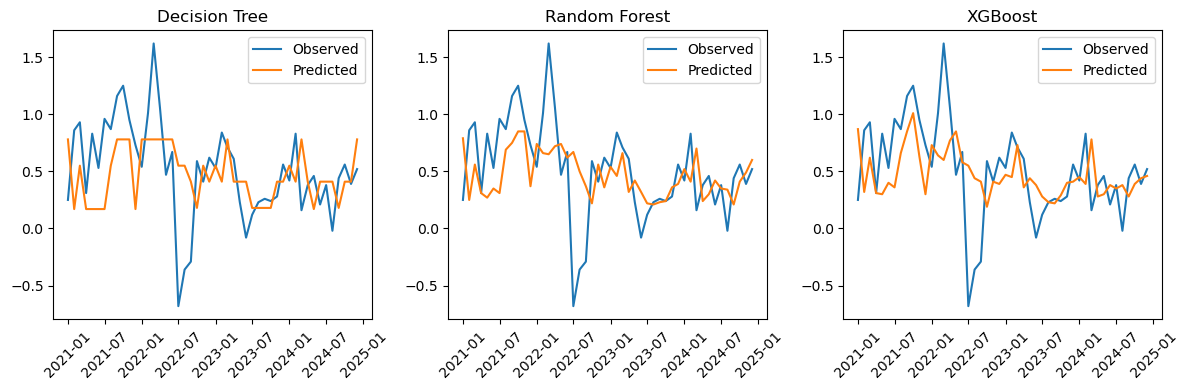

In [51]:
plt.figure(figsize=(12,4))

for n,i in enumerate(model_pred.columns[1:]):
    plt.subplot(1,3,n+1)
    plt.title(i)
    plt.plot(model_pred['Observed'], label='Observed')
    plt.plot(model_pred[i], label='Predicted')
    plt.legend()
    plt.xticks(rotation=45)

plt.tight_layout()

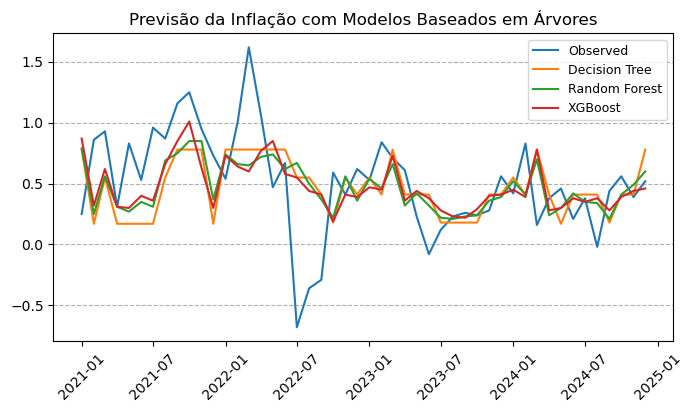

In [103]:
plt.figure(figsize=(8,4))

plt.title('Previsão da Inflação com Modelos Baseados em Árvores')
plt.plot(model_pred, label = model_pred.columns)
plt.legend(fontsize=9)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='dashed')

**Estatísticas de Erro**

- ME: Erro médio, indica a direção e a magnitude média dos erros, podendo ser positivo ou negativo.
- MAE: Média dos erros absolutos, mede a precisão geral ignorando o sinal dos erros.
- RMSE: Raiz da média dos erros quadráticos, dá mais peso a erros maiores e destaca desvios significativos.
- MPE: Erro percentual médio, calcula a média dos erros relativos, considerando sua direção (positivo ou negativo).
- MAPE: Erro percentual médio absoluto, mede a precisão em termos percentuais, ignorando o sinal dos erros.

In [54]:
# Função para gerar as estatísticas de erro
def erros(previstos, observados):
    
    teste_values = observados
    previstos_values = previstos
    
    erro = teste_values - previstos_values
    
    # Calculo do Erro Medio
    merror = sum(erro)/len(erro)
    
    # Calculo do Erro Absoluto Medio
    mae = mean_absolute_error(teste_values, previstos_values)

    # Calculo da Raiz Quadrada do Erro Medio
    rmse = root_mean_squared_error(teste_values, previstos_values)

    # Calculo do Erro Percentual Medio
    erro_percentual = (teste_values - previstos_values)/teste_values
    mpe = me = sum(erro_percentual)/len(erro)

    # Calculo do Erro Absoluto Percentual Medio
    mape = mean_absolute_percentage_error(teste_values, previstos_values)
    
    df_erros = pd.DataFrame({
        "Métrica": ["ME", "MAE", "RMSE", "MPE", "MAPE"],
        "Descrição": [
        "Mean Error",
        "Mean Absolute Error",
        "Root Mean Square Error",
        "Mean Percentage Error",
        "Mean Absolute Percentage Error"],
        "Valor": [merror, mae, rmse, mpe, mape]
    })
    
    return df_erros

In [97]:
df_erros = erros(model_pred.iloc[:,1], y_test)
df_erros = df_erros.rename(columns={'Valor': 'Decision Tree'})
df_erros['Random Forest'] = erros(model_pred.iloc[:,2], y_test).iloc[:,-1]
df_erros['XGBoost'] = erros(model_pred.iloc[:,3], y_test).iloc[:,-1]
df_erros

,Métrica,Descrição,Decision Tree,Random Forest,XGBoost
0,ME,Mean Error,0.044583,0.042292,0.037917
1,MAE,Mean Absolute Error,0.329583,0.300625,0.296667
2,RMSE,Root Mean Square Error,0.423054,0.404447,0.398607
3,MPE,Mean Percentage Error,0.725328,0.613592,0.639999
4,MAPE,Mean Absolute Percentage Error,1.202785,1.049344,1.116498
